In [1]:
import os
import math
import numpy as np

import torch
from torchvision import transforms
from torchvision.transforms import functional as TF
from torch.utils.data import DataLoader
from datasets import load_dataset
from tqdm import tqdm

from GeospatialFM.datasets.utils import get_ssl4eo_metadata
from GeospatialFM.data import apply_transforms, pretrain_transform, multimodal_collate_fn
from GeospatialFM.models import SpatialSpectralLowRankViTConfig, SpatialSpectralMAEViT
from GeospatialFM.models.low_rank_attention import get_perception_field_mask
from GeospatialFM.models import PositionalChannelEmbedding
from GeospatialFM.datasets import SSL4EODataset
from GeospatialFM.scripts.trainer import MAETrainer

from functools import partial
from accelerate import Accelerator
from transformers import TrainingArguments

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import rasterio
import pandas as pd
import json

%load_ext autoreload
%autoreload 2

/home/haozhesi/anaconda3/envs/sat/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Perception Field Mask

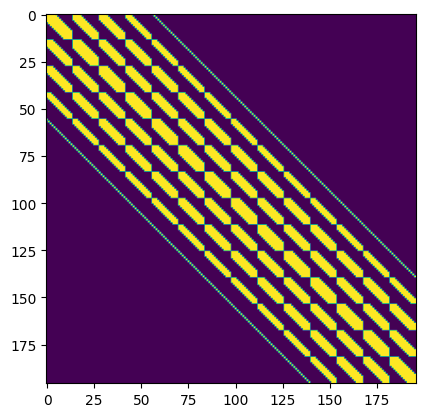

In [2]:
patch_size = 16
num_patches = 196
perception_field_mask = get_perception_field_mask(num_patches, patch_size, 10, attention_radius=640, cls_token=False)
perception_field_mask.shape
plt.imshow(perception_field_mask.numpy())

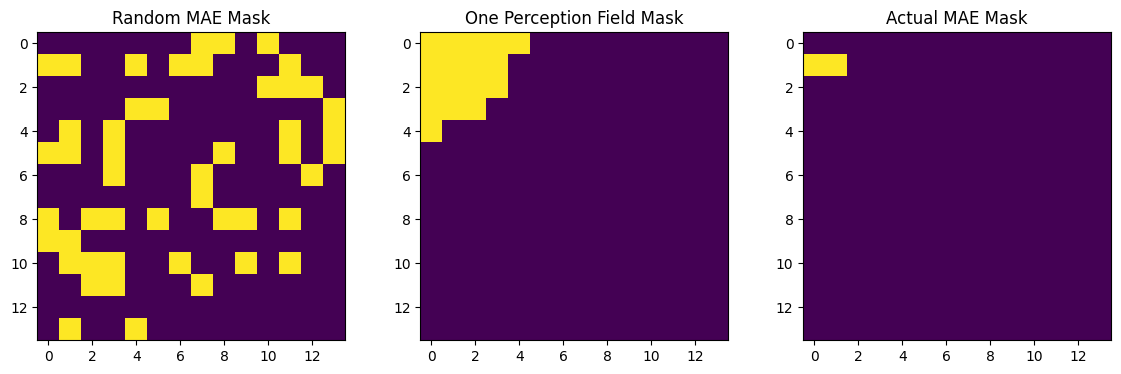

In [3]:
one_perception = perception_field_mask[0].reshape(int(math.sqrt(perception_field_mask.shape[1])), int(math.sqrt(perception_field_mask.shape[1]))).numpy()
idx = torch.rand(num_patches)
keep_idx = torch.argsort(idx)[:int(num_patches*0.25)]
random_mask = torch.zeros(num_patches)
random_mask[keep_idx] = 1
random_mask = random_mask.reshape(int(math.sqrt(num_patches)), int(math.sqrt(num_patches)))
fig, ax = plt.subplots(1, 3, figsize=(14, 4))
ax[0].imshow(random_mask.numpy())
ax[0].set_title("Random MAE Mask")
ax[1].imshow(one_perception, vmin=0, vmax=1)
ax[1].set_title("One Perception Field Mask")
ax[2].imshow(random_mask.numpy() * one_perception)
ax[2].set_title("Actual MAE Mask")
plt.show()
# print(perception_field_mask[0].reshape(int(math.sqrt(perception_field_mask.shape[1])), int(math.sqrt(perception_field_mask.shape[1]))).numpy().sum())

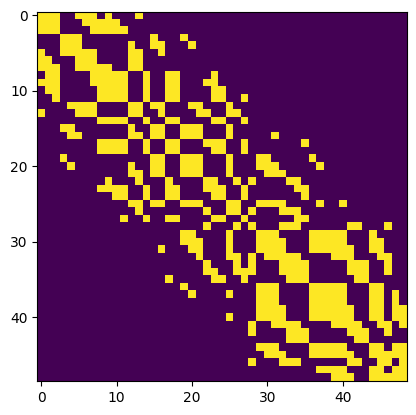

In [4]:
# apply random mask to perception field mask
random_mask_idx = random_mask.reshape(-1).nonzero().squeeze()
perception_field_mask_masked = perception_field_mask[random_mask_idx][:, random_mask_idx]
plt.imshow(perception_field_mask_masked.numpy())

## PositionalChannel Embedding

In [5]:
pos_chan_embed = PositionalChannelEmbedding(embed_dim=768)
tokens = torch.randn(1, 5, 196, 768)
channel_ids = torch.arange(5).unsqueeze(0) * 1000
pos_embed = pos_chan_embed(tokens, 10, channel_ids, cls_token=False).squeeze(0)
print(pos_embed.shape)

torch.Size([5, 196, 768])


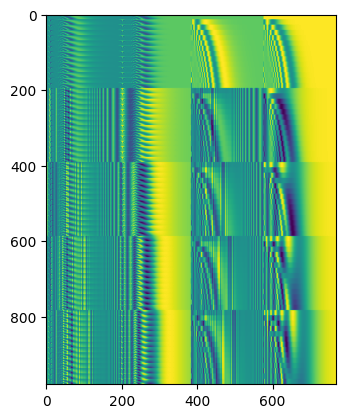

In [6]:
# print the embedding of the first channel
plt.imshow(torch.cat([pos_embed[i] for i in range(5)], dim=0))

## SSL4EO

In [7]:
metadata = get_ssl4eo_metadata()
optical_mean, optical_std = metadata["s2c"]["mean"], metadata["s2c"]["std"]
radar_mean, radar_std = metadata["s1"]["mean"], metadata["s1"]["std"]

In [8]:
# dataset = load_dataset("GeospatialFM/datasets/ssl4eo", data_dir="/home/haozhesi/Dropbox/GeospatialFM/data/geospatial/SSL4EO", keep_in_memory=False)
dataset = dict(train=SSL4EODataset(root="/home/haozhesi/Dropbox/GeospatialFM/data/geospatial/SSL4EO"))
apply_transform = partial(apply_transforms, optical_mean=optical_mean, optical_std=optical_std, radar_mean=radar_mean, radar_std=radar_std)
# dataset = dataset.map(apply_transform)

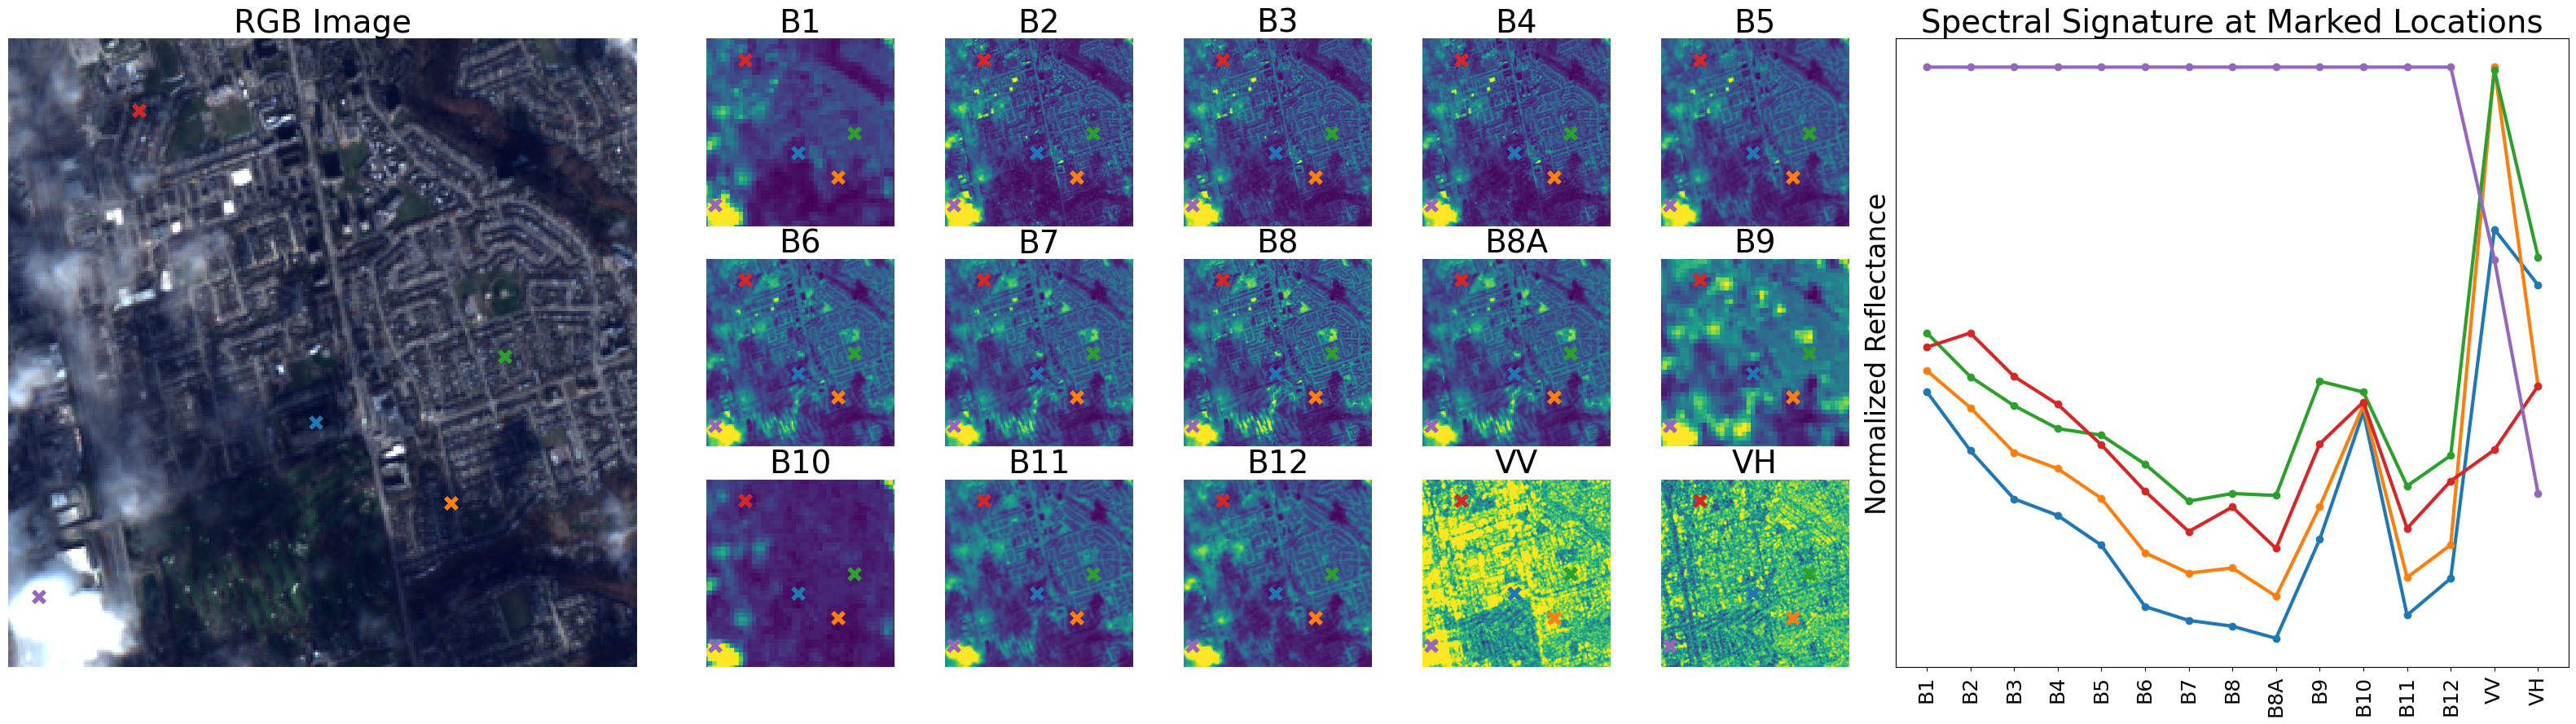

In [13]:
def norm_img(img):
    return (img - img.min()) / (img.max() - img.min())

data_idx = np.random.randint(0, len(dataset['train']))
data_idx = 117967
# print(data_idx)
sample = apply_transform(dataset['train'][data_idx])
sample_optical_image = torch.tensor(sample['optical']).numpy()
sample_radar_image = torch.tensor(sample['radar']).numpy()
sample_image = np.concatenate([sample_optical_image, sample_radar_image], axis=0)
bands = metadata["s2c"]["bands"] + metadata["s1"]["bands"]
rgb_image = sample_optical_image[[3, 2, 1]].transpose(1, 2, 0)
rgb_image = norm_img(rgb_image)

# visualize a data sample
mpl.rcParams['axes.titlesize'] = 28
mpl.rcParams['axes.labelsize'] = 24
mpl.rcParams['xtick.labelsize'] = 18
mpl.rcParams['ytick.labelsize'] = 18

# Number of images excluding the RGB image
num_images = sample_image.shape[0]
# pick the 75 quantile location of each channel
random_locs = []
target_labels = []

for i in [0, 0.25, 0.5, 0.75, 1]:
    quantile = int(sample_image[1].size*i) if i != 1 else -1
    loc = np.unravel_index(np.argsort(sample_image[1].flatten())[quantile], sample_image[1].shape)
    random_locs.append(loc)
    target_labels.append(f"{i*100}%")

# Create a figure
fig = plt.figure(figsize=(32, 9))  # Adjust the figure size as needed

# Create a GridSpec with 3 rows and 8 columns
gs = GridSpec(3, 11, figure=fig)

ax_img = fig.add_subplot(gs[:, :3])
ax_img.imshow(rgb_image)
ax_img.axis('off')
ax_img.set_title('RGB Image')
for loc in random_locs:
    ax_img.plot(loc[1], loc[0], 'x', markersize=10, markeredgewidth=4)

# The rest of the images (adjust the range according to your number of images)
for i in range(num_images):
    # Calculate the position for the current image
    row = i // 5
    col = i % 5 
    ax = fig.add_subplot(gs[row, col+3])
    ax.imshow(sample_image[i])  # Replace with each individual image array
    # plot cross at random locations
    for loc in random_locs:
        ax.plot(loc[1], loc[0], 'x', markersize=10, markeredgewidth=4)
    # bold the title
    ax.set_title(f"{bands[i]}")  # Replace with the title for each image
    ax.axis('off')

ax_curve = fig.add_subplot(gs[:, -3:])
for loc, label in zip(random_locs, target_labels):
    ax_curve.plot(np.arange(len(bands)), sample_image[:, loc[0], loc[1]], linewidth=3, marker='o', markersize=6, label=label)
# ax_curve.legend(loc='upper right', fontsize=18)
# ax_curve.set_xlabel('Bands')
ax_curve.set_ylabel('Normalized Reflectance')
ax_curve.set_title('Spectral Signature at Marked Locations')
ax_curve.set_yticks([])
# set the band names as xticks
ax_curve.set_xticks(np.arange(len(bands)))
ax_curve.set_xticklabels(bands, rotation=90)

plt.tight_layout()
# plt.show()
# save as pdf
plt.savefig('spectral_signature.pdf', bbox_inches='tight', pad_inches=0.1)

## Dataloader with Image Size Changing

In [5]:
batch_size = 8

collate_fn = partial(multimodal_collate_fn, transform=pretrain_transform, normalization=apply_transform)

train_loader = DataLoader(
    dataset['train'], 
    batch_size=batch_size, 
    shuffle=True, 
    num_workers=4, 
    collate_fn=collate_fn
)

# for n, batch in enumerate(train_loader):
#     print(batch['optical'].shape)
#     if n == 4:
#         break

## Model

In [6]:
# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Define configuration
config = SpatialSpectralLowRankViTConfig(
    patch_size=16,
    embed_dim=768,
    depth=12,
    num_heads=12,
    decoder_embed_dim=512,
    decoder_depth=8,
    decoder_num_heads=16,
    use_perception_field_mask=True,
    attention_radius=640,
    norm_pix_loss=False,
)

# Initialize model
model = SpatialSpectralMAEViT(config)

model

SpatialSpectralMAEViT(
  (encoder): SpatialSpectralLowRankViTEncoder(
    (optical_patch_embed): HyperspectralPatchEmbed(
      (proj): Conv3d(1, 768, kernel_size=(1, 16, 16), stride=(1, 16, 16))
    )
    (radar_patch_embed): HyperspectralPatchEmbed(
      (proj): Conv3d(1, 768, kernel_size=(1, 16, 16), stride=(1, 16, 16))
    )
    (blocks): ModuleList(
      (0-11): 12 x LowRankBlock(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): LowRankAttention(
          (channel_pool): AttentionPool(
            (qkv): Linear(in_features=768, out_features=2304, bias=True)
            (q_norm): Identity()
            (k_norm): Identity()
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=768, out_features=48, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
            (norm): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          )
          (spatial_pool): AttentionPool(
            (qk

In [7]:
# find the number of parameters
num_params = sum(p.numel() for p in model.encoder.parameters())
print(f"Number of parameters: {num_params}")

Number of parameters: 110383104


## Training Code

In [8]:
# Set model to training mode
model.to('cuda:0', dtype=torch.bfloat16)
model.train()

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

# # load checkpoint
# model.load_state_dict(torch.load("/home/haozhesi/Dropbox/GeospatialFM/results/models/LRSSVIT/checkpoint-1000/pytorch_model.bin"))

In [9]:
for batch in tqdm(train_loader):
    optical = batch['optical'].to('cuda:0', dtype=torch.bfloat16)
    radar = batch['radar'].to('cuda:0', dtype=torch.bfloat16)
    optical_channel_wv = batch['optical_channel_wv']
    radar_channel_wv = batch['radar_channel_wv']
    spatial_resolution = batch['spatial_resolution']
    # Run forward pass
    output = model(
        optical=optical,
        radar=radar,
        optical_channel_wv=optical_channel_wv,
        radar_channel_wv=radar_channel_wv,
        mask_ratio=0.75,
        channel_mask_ratio=0.5,
        spatial_resolution=spatial_resolution,
    )
    break

# Check output
expected_keys = [
    'target',
    'optical_channel_mask', 'optical_recon', 'optical_pos_mask',
    'radar_channel_mask', 'radar_recon', 'radar_pos_mask',
    'multi_channel_mask', 'multi_recon', 'multi_pos_mask'
]

for key in expected_keys:
    assert key in output, f"Missing key in output: {key}"
    assert isinstance(output[key], torch.Tensor), f"Output {key} is not a tensor"

  0%|          | 0/31385 [00:00<?, ?it/s]

optical_recon dtype torch.bfloat16


  0%|          | 0/31385 [00:01<?, ?it/s]


In [10]:
# manually compute the loss
loss = {}
total_loss = 0
target = output['target']
for modal in ['optical', 'radar', 'multi']:
    if f'{modal}_recon' in output:
        recon = output[f'{modal}_recon']
        channel_mask = output[f'{modal}_channel_mask']
        pos_mask = output[f'{modal}_pos_mask']
        # positional MSE
        pos_loss = (torch.mean((recon - target) ** 2, dim=[1, 3]) * pos_mask).sum() / pos_mask.sum()
        # channel MSE
        channel_loss = (torch.mean((recon - target) ** 2, dim=[2, 3]) * channel_mask).sum() / channel_mask.sum()
        loss[f"{modal}_pos_loss"] = pos_loss
        loss[f"{modal}_channel_loss"] = channel_loss
        loss[f"{modal}_loss"] = pos_loss + channel_loss
        total_loss += loss[f"{modal}_loss"]
loss['total_loss'] = total_loss
print(loss)

pos_loss tensor(1.4888, device='cuda:0', grad_fn=<DivBackward0>) tensor(384., device='cuda:0') torch.Size([8, 15, 64, 256]) torch.Size([8, 15, 64, 256]) torch.Size([8, 64])
channel_loss tensor(1.4952, device='cuda:0', grad_fn=<DivBackward0>) tensor(72., device='cuda:0') torch.Size([8, 15, 64, 256]) torch.Size([8, 15, 64, 256]) torch.Size([8, 15])
pos_loss tensor(1.4832, device='cuda:0', grad_fn=<DivBackward0>) tensor(384., device='cuda:0') torch.Size([8, 15, 64, 256]) torch.Size([8, 15, 64, 256]) torch.Size([8, 64])
channel_loss tensor(1.4558, device='cuda:0', grad_fn=<DivBackward0>) tensor(104., device='cuda:0') torch.Size([8, 15, 64, 256]) torch.Size([8, 15, 64, 256]) torch.Size([8, 15])
pos_loss tensor(1.4760, device='cuda:0', grad_fn=<DivBackward0>) tensor(384., device='cuda:0') torch.Size([8, 15, 64, 256]) torch.Size([8, 15, 64, 256]) torch.Size([8, 64])
channel_loss tensor(1.4818, device='cuda:0', grad_fn=<DivBackward0>) tensor(64., device='cuda:0') torch.Size([8, 15, 64, 256]) t

In [11]:
# step
optimizer.zero_grad()
total_loss.backward()
optimizer.step()